In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Load the dataset
df = pd.read_csv('data/df.csv')
df.head()

,child_had_diarrhoea_last_two_weeks,child_ill_fever_two_weeks,child_ill_cough_two_weeks,child_weight_kg,child_lenhei_cm,area,region,sex,age_months,age_months_6,age_months_11,age_days,mother_educational_level,health_insurance,mother_functional_disability_18_49,ethnicity,combined_wealth_score,wealth_index_quintile,wealth_index_decile,stunting
0,No,No,No,9.5,77.8,Rural,Western,Male,20,12-23,12-23,622,Jss/jhs/middle,With insurance,Has no functional difficulty,Akan,0.153212,Middle,6th decile,Stunting
1,Yes,No,Yes,7.0,70.6,Rural,Western,Female,14,12-23,12-23,431,Primary,Without insurance,Has functional difficulty,Akan,-0.068991,Middle,5th decile,Stunting
2,No,Yes,No,11.9,95.3,Rural,Western,Female,42,36-47,36-47,1295,Jss/jhs/middle,Without insurance,Has no functional difficulty,Akan,-0.263641,Middle,5th decile,Normal
3,No,Yes,No,9.8,78.6,Rural,Western,Female,17,12-23,12-23,532,Jss/jhs/middle,Without insurance,Has no functional difficulty,Akan,-0.263641,Middle,5th decile,Normal
4,No,No,Yes,14.9,100.1,Rural,Western,Male,52,48-59,48-59,1607,Primary,With insurance,Has no functional difficulty,Akan,0.087765,Middle,6th decile,Normal


In [9]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# Splitting the data into training and test sets
X = df.drop('stunting', axis=1)
y = df['stunting']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6071, 19), (2603, 19), (6071,), (2603,))

In [10]:
# Using a base Random Forest model to identify important features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
features = X.columns
important_features = pd.Series(feature_importances, index=features).nlargest(5)
important_features

child_lenhei_cm          0.310172
age_days                 0.154017
child_weight_kg          0.128284
age_months               0.106560
combined_wealth_score    0.060253
dtype: float64

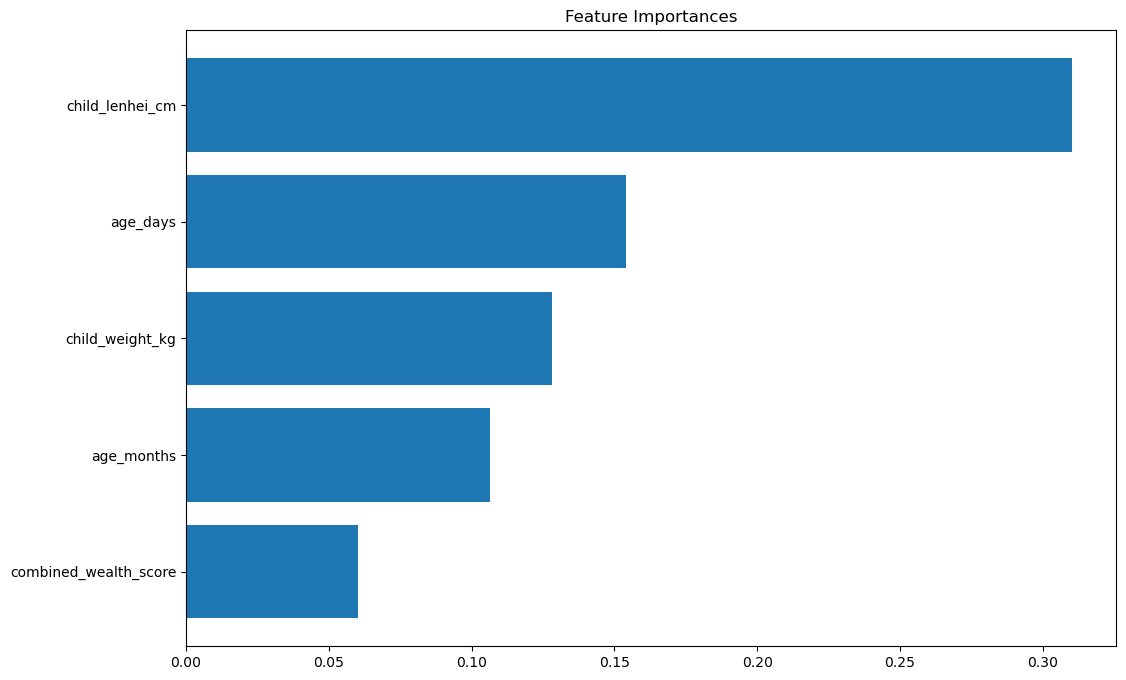

In [12]:
# Plot feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(important_features)[::-1]
plt.title('Feature Importances')
plt.barh(range(len(important_features)), important_features[indices], align='center')
plt.yticks(range(len(important_features)), [important_features.index[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Selecting the top 5 important features for training
selected_features = important_features.index.tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Ridge Regression': RidgeClassifier(random_state=42),
    'LASSO': Lasso(alpha=0.1),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier()
}

# Training and evaluating models
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

results

In [ ]:
# Visualizing the accuracy of each model
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting ROC curves for each model
plt.figure(figsize=(12, 8))

for name, model in models.items():
    # Predict probabilities
    probas = model.predict_proba(X_test_selected)
    fpr, tpr, thresholds = roc_curve(y_test_encoded, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Model Recommendation
Based on the accuracy results and the AUC values from the ROC curves, we can make a recommendation on the best model for predicting stunting.

The model with the highest accuracy and AUC value will be considered the best model for this task. Let's analyze the results and provide a recommendation.